# Exploring Dandiset 000617: Allen Institute Openscope - Sequence Learning Project

*Generated with the assistance of AI. Please review code and results carefully before drawing scientific conclusions.*

---

This notebook provides an introduction and exploration guide for [Dandiset 000617 (version 0.250311.1615)](https://dandiarchive.org/dandiset/000617/0.250311.1615):  
**Allen Institute Openscope - Sequence Learning Project**.

This Dandiset contains extensive two-photon calcium imaging data from mouse neocortex acquired during a sequence learning task. Mice were presented with sequences of natural movie clips while imaging was performed across multiple visual cortical areas and layers. The data includes:

- Processed calcium imaging (fluorescence, dF/F, events)
- ROI segmentation and mask info
- Raw and motion-corrected movies
- Pupil and eye-tracking data
- Running speed and behavioral events
- Detailed stimulus presentation timing

This notebook shows how to access and explore these datasets directly from the DANDI Archive, including a detailed walkthrough using a representative NWB file.

---

**What this notebook covers:**

1. Quick summary of the Dandiset and experiment design.
2. Overview of required Python packages.
3. How to use the DANDI API to list and access available assets.
4. How to stream and load NWB data (without full download).
5. How to extract and visualize example data:
    - Calcium imaging ROIs and fluorescence traces
    - ROI geometric info and masks
    - Running and behavioral data
    - Stimulus intervals/excerpts
    - Eye and pupil tracking

Explanatory remarks and code comments are included throughout.  
_Let's get started!_

---

## Required packages

This notebook assumes you have the following packages installed:

- `dandi` (for DANDI API access)
- `remfile` (for remote file streaming)
- `h5py` (to access NWB files as HDF5)
- `pynwb` (to interact with NWB file contents)
- `matplotlib` and `seaborn` (for plotting)
- `pandas`, `numpy` (for data handling)

No installation commands are included (see the [DANDI documentation](https://www.dandiarchive.org/) for more information).

---

## 1. Dandiset Summary

- **Project title:** Allen Institute Openscope - Sequence Learning Project
- **Organisms:** Mus musculus (house mouse)
- **Sample size:** 13 subjects, >1000 files, >13 TB of data
- **Approaches:** Two-photon mesoscope calcium imaging, Eye tracking, Running wheel, Visual stimuli
- **Areas:** V1 (VISp), LM (VISl), AM (VISam), PM (VISpm); Cortical layers 2/3 and 4
- **Genotype:** Cux2-CreERT2;Camk2a-tTA;Ai93(TITL-GCaMP6f)

_For more details, see the full Dandiset record:_  
[https://dandiarchive.org/dandiset/000617/0.250311.1615](https://dandiarchive.org/dandiset/000617/0.250311.1615)

---

## 2. Connecting to the DANDI Archive and Locating Example NWB Files

We'll use the DANDI API to query the Dandiset, list files, and select one sample NWB file for exploration.

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from dandi.dandiapi import DandiAPIClient

# Connect to the DANDI archive and Dandiset 000617 (specific version)
dandiset_id = "000617"
dandiset_version = "0.250311.1615"

client = DandiAPIClient()
dandiset = client.get_dandiset(dandiset_id, dandiset_version)

# List a subset of files for subject 684475
print("First few NWB files for subject 684475:")
file_listing = list(dandiset.get_assets_by_glob("sub-684475/*.nwb"))
for f in file_listing[:5]:
    print("-", f.path)

First few NWB files for subject 684475:
- sub-684475/sub-684475_ses-1294084428-acq-1294179945-raw-movies_ophys.nwb
- sub-684475/sub-684475_ses-1294084428-acq-1294179943-raw-movies_ophys.nwb
- sub-684475/sub-684475_ses-1293785946-acq-1293914859-raw-movies_ophys.nwb
- sub-684475/sub-684475_ses-1294084428-acq-1294179942-raw-movies_ophys.nwb
- sub-684475/sub-684475_ses-1294259213-acq-1294370666-raw-movies_ophys.nwb


_**Note:**_ File names in this dandiset follow the convention:  
`sub-{SUBJECT_ID}/sub-{SUBJECT_ID}_ses-{SESSION_ID}-acq-{ACQ_ID}-raw-movies_ophys.nwb`

In this tutorial, we'll use the file:
```
sub-684475/sub-684475_ses-1294084428-acq-1294179945-raw-movies_ophys.nwb
```
as an illustrative example, but you can use this workflow for any NWB file in the Dandiset.

## 3. Streaming and Loading NWB Files from DANDI (no download needed)

Let's stream the selected file using `remfile` and examine its NWB structure with `pynwb` and `h5py`.

---

In [2]:
import remfile
import h5py
import pynwb

# Get the download URL for the example file
nwb_path = "sub-684475/sub-684475_ses-1294084428-acq-1294179945-raw-movies_ophys.nwb"
asset = next(dandiset.get_assets_by_glob(nwb_path))
url = asset.download_url
print("Streaming from:", url)

# Open file via remote streaming
remote_file = remfile.File(url)
h5_file = h5py.File(remote_file)

# Open with NWBHDF5IO for inspection with pynwb (read mode)
io = pynwb.NWBHDF5IO(file=h5_file)
nwb = io.read()

Streaming from: https://api.dandiarchive.org/api/dandisets/000617/versions/0.250311.1615/assets/3eaf1acf-7a63-4286-a7c0-7a58d8cae2f8/download/


/home/magland/miniconda3/envs/dev/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/magland/miniconda3/envs/dev/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.3.0 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/magland/miniconda3/envs/dev/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


## 4. NWB Structure and High-level Metadata

Let's inspect general information about this NWB session:  
- Session details
- Subject info
- Keywords and notes
- Experimental description

### Session Metadata

In [3]:
print("NWB session identifier:", nwb.identifier)
print("Session start:", nwb.session_start_time)
print("Experiment description:", nwb.experiment_description)
print("Institution:", nwb.institution)
print("Subject info:", nwb.subject)
print("Subject genotype:", nwb.subject.genotype)
print("Subject sex:", nwb.subject.sex)
print("Keywords:", nwb.keywords[:])

NWB session identifier: 1294179945
Session start: 2023-08-31 20:49:56.751000+00:00
Experiment description: ophys session
Institution: Allen Institute for Brain Science
Subject info: subject pynwb.file.Subject at 0x125433166005792
Fields:
  age: P108.0D
  description: external: 684475 donor_id: (1281520997,) specimen_id: ['684475']
  genotype: Cux2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/wt
  sex: M
  species: Mus musculus
  subject_id: 684475

Subject genotype: Cux2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/wt
Subject sex: M
Keywords: ['2-photon' 'calcium imaging' 'visual cortex' 'behavior' 'task']


## 5. Exploring Calcium Imaging Data: ROIs and Fluorescence Traces

The "ophys" processing module contains:
- **corrected_fluorescence** (raw/neuropil-subtracted)
- **dff** (ΔF/F)
- **event_detection** (binary or weighted event times)
- **neuropil_trace**

Let's extract ROI info and plot some example traces.

### ROI Segmentation Table

Let's inspect the ROI table:  
(Each row = cell, with properties and mask for image segmentation)

In [4]:
# Access the ophys processing module and get main tables
ophys = nwb.processing["ophys"]
roi_table = ophys.data_interfaces["image_segmentation"].plane_segmentations["cell_specimen_table"].to_dataframe()

print("ROI table shape:", roi_table.shape)
display(roi_table.head())

ROI table shape: (18, 12)


,cell_specimen_id,height,mask_image_plane,max_correction_down,max_correction_left,max_correction_right,max_correction_up,valid_roi,width,x,y,image_mask
id,,,,,,,,,,,,
1294200207,-1,18,0,6.0,12.0,9.0,13.0,True,19,60,470,"[[False, False, False, False, False, False, Fa..."
1294200209,-1,22,0,6.0,12.0,9.0,13.0,True,20,217,442,"[[False, False, False, False, False, False, Fa..."
1294200210,-1,17,0,6.0,12.0,9.0,13.0,True,22,298,477,"[[False, False, False, False, False, False, Fa..."
1294200212,-1,15,0,6.0,12.0,9.0,13.0,True,16,46,379,"[[False, False, False, False, False, False, Fa..."
1294200216,-1,17,0,6.0,12.0,9.0,13.0,True,26,108,366,"[[False, False, False, False, False, False, Fa..."


### Show ROI locations over the Field-of-View

_Note:_ To avoid overflow/casting errors, we use an integer array with a sufficient dtype for mask accumulation.

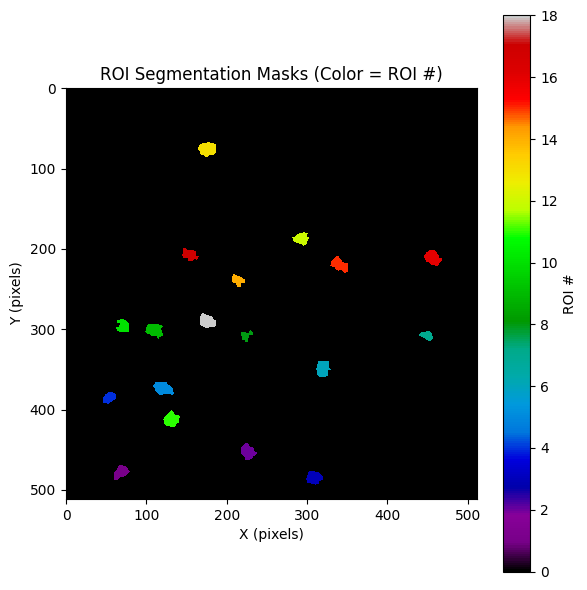

In [5]:
field_of_view_shape = (512, 512)
roi_mask_array = np.zeros(field_of_view_shape, dtype=np.int32)

for idx, mask in enumerate(roi_table['image_mask']):
    # Ensure mask is cast to an int (bools), and add unique ROI number to nonzero locations
    roi_mask_array = np.where(mask > 0, idx+1, roi_mask_array)

plt.figure(figsize=(6, 6))
plt.imshow(roi_mask_array, cmap='nipy_spectral', interpolation='nearest')
plt.title('ROI Segmentation Masks (Color = ROI #)')
plt.xlabel('X (pixels)')
plt.ylabel('Y (pixels)')
plt.colorbar(label='ROI #')
plt.tight_layout()
plt.show()

### ROI Geometry Overview

Let's summarize the distribution of ROI (cell) sizes and locations.

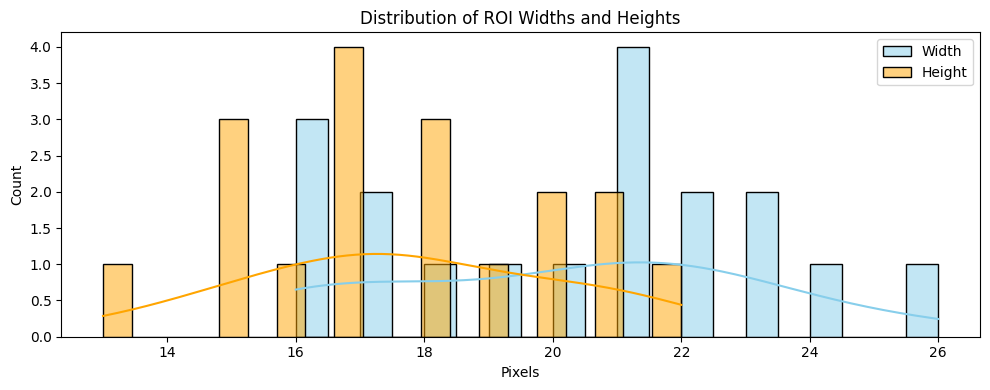

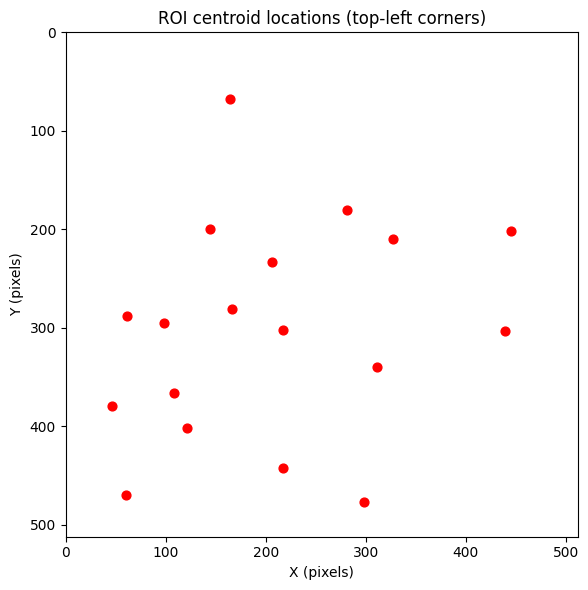

In [6]:
plt.figure(figsize=(10, 4))
sns.histplot(roi_table["width"], bins=20, color='skyblue', label='Width', kde=True)
sns.histplot(roi_table["height"], bins=20, color='orange', label='Height', kde=True)
plt.legend()
plt.title("Distribution of ROI Widths and Heights")
plt.xlabel("Pixels")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(roi_table["x"], roi_table["y"], c="r", s=40)
plt.title("ROI centroid locations (top-left corners)")
plt.xlabel("X (pixels)")
plt.ylabel("Y (pixels)")
plt.xlim(0, field_of_view_shape[1])
plt.ylim(field_of_view_shape[0], 0)
plt.tight_layout()
plt.show()

### ΔF/F Traces for All Cells (First 2 Minutes)

Let's plot ΔF/F for all ROIs in the first 120 seconds.  
This shows synchronous and individual cell activity over time.

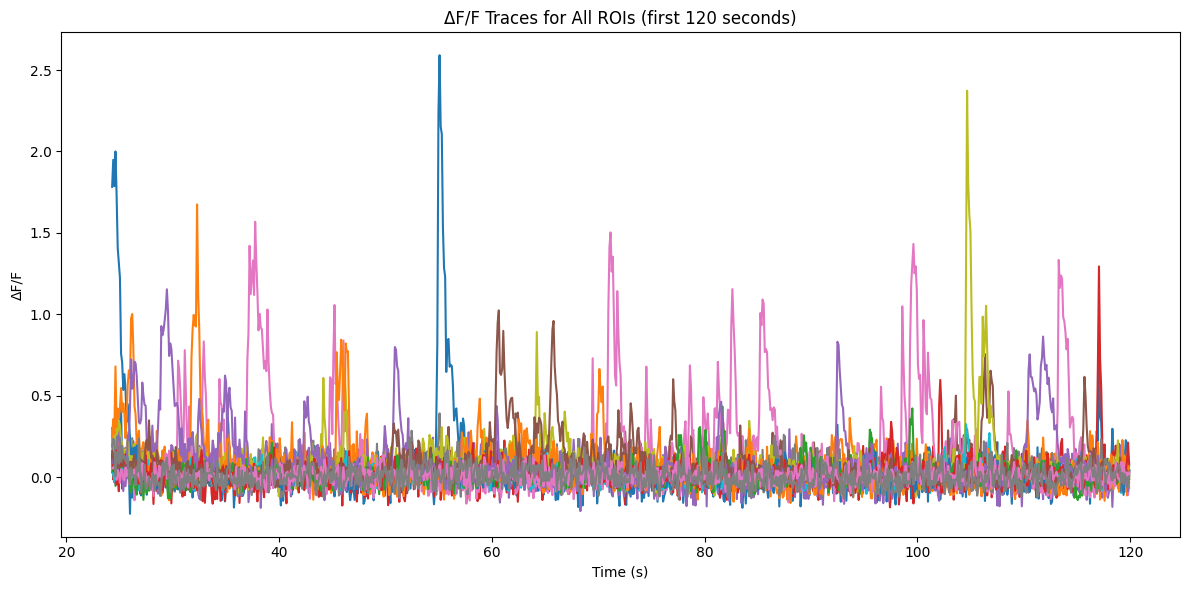

In [7]:
# Get dF/F traces and timestamps
dff = ophys.data_interfaces["dff"]
dff_traces = dff.roi_response_series["traces"].data[:]
dff_timestamps = dff.roi_response_series["traces"].timestamps[:]

# Restrict to first 120 seconds
mask = dff_timestamps < 120
plt.figure(figsize=(12, 6))
plt.plot(dff_timestamps[mask], dff_traces[mask])
plt.title("ΔF/F Traces for All ROIs (first 120 seconds)")
plt.xlabel("Time (s)")
plt.ylabel("ΔF/F")
plt.tight_layout()
plt.show()

## 6. Exploring Event Detection Output

The event detection module provides putative neural event times for each cell on a frame-by-frame basis.

Let's plot event traces for the first few ROIs.

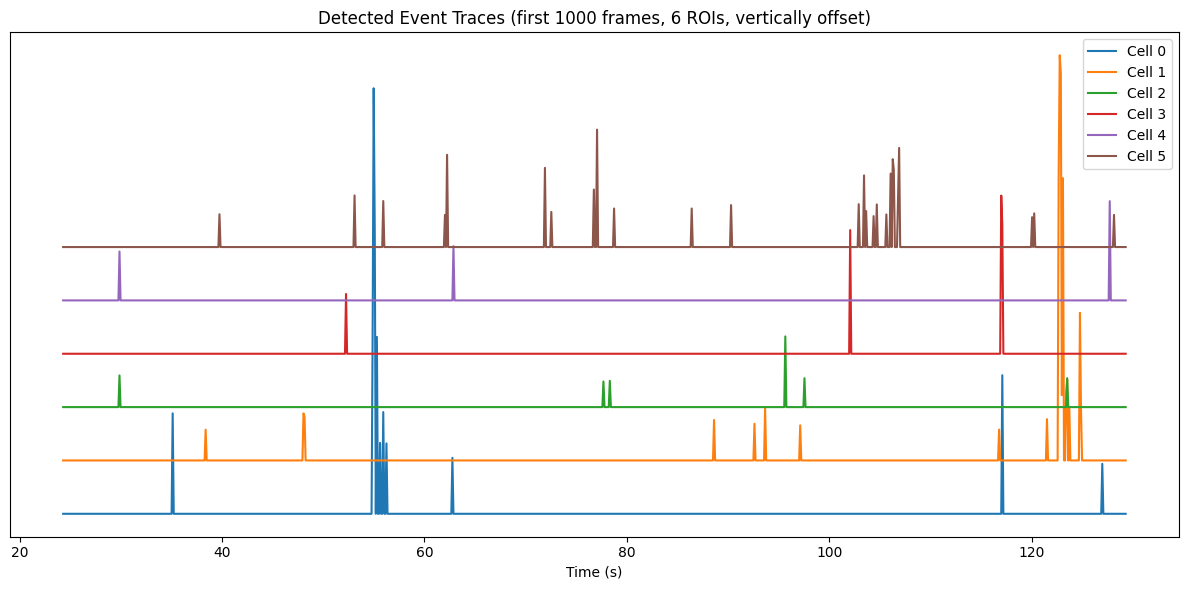

In [8]:
event_detection = ophys.data_interfaces["event_detection"]
event_data = event_detection.data[:]
event_timestamps = event_detection.timestamps[:]

n_show = 6  # number of ROIs to plot
plt.figure(figsize=(12, 6))
for i in range(n_show):
    plt.plot(event_timestamps[:1000], event_data[:1000, i] + i*0.2, label=f'Cell {i}')
plt.xlabel("Time (s)")
plt.title("Detected Event Traces (first 1000 frames, 6 ROIs, vertically offset)")
plt.yticks([])
plt.legend()
plt.tight_layout()
plt.show()

## 7. Viewing the Mean and Max Projection Images

Useful for context—what does the FOV look like?

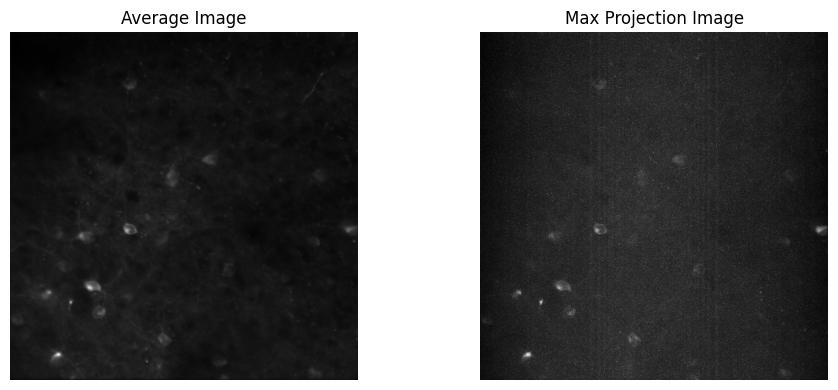

In [9]:
images = ophys.data_interfaces["images"].images
average_img = images["average_image"].data[:]
max_proj_img = images["max_projection"].data[:]

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(average_img, cmap='gray')
plt.title("Average Image")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(max_proj_img, cmap='gray')
plt.title("Max Projection Image")
plt.axis("off")
plt.tight_layout()
plt.show()

## 8. Behavioral and Running Speed Data

This session includes synchronized running wheel data (raw and processed speed).  
Let's inspect running speed over time.

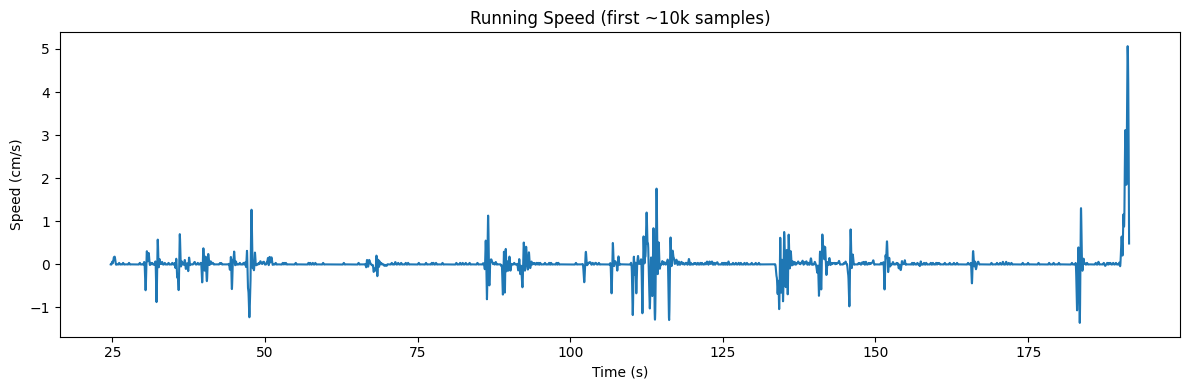

In [10]:
running = nwb.processing["running"].data_interfaces
speed = running["speed"]
speed_vals = speed.data[:]
speed_times = speed.timestamps[:]

plt.figure(figsize=(12, 4))
plt.plot(speed_times[:10000], speed_vals[:10000])  # Show a subset for clarity
plt.xlabel("Time (s)")
plt.ylabel("Speed (cm/s)")
plt.title("Running Speed (first ~10k samples)")
plt.tight_layout()
plt.show()

## 9. Eye and Pupil Tracking Overview

Multiple eye features are tracked: pupil, corneal reflection, and blinks.  
Let's show example pupil size and position, plus blink trace.

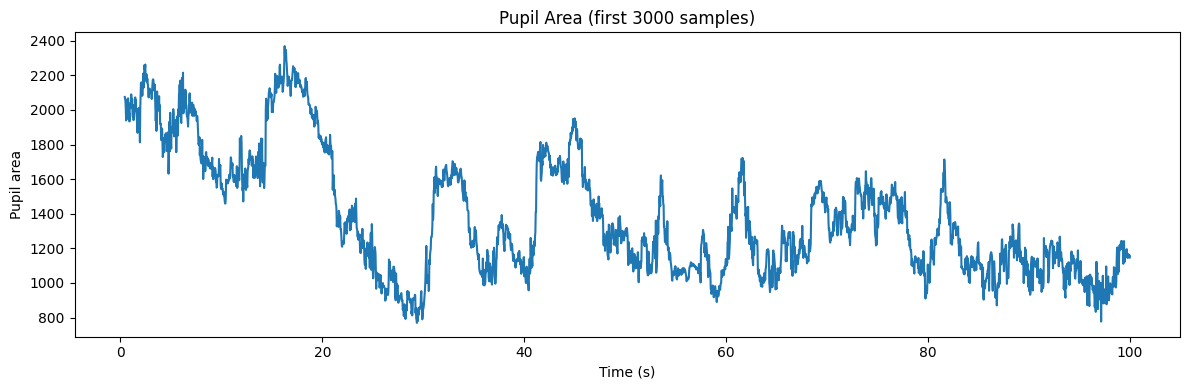

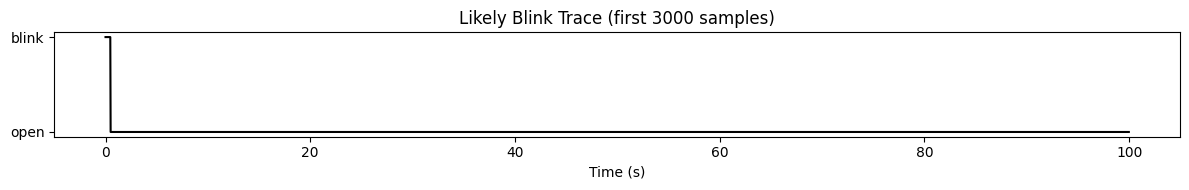

In [11]:
eye = nwb.acquisition["EyeTracking"].spatial_series
pupil_data = eye["pupil_tracking"].data[:]
pupil_area = eye["pupil_tracking"].area[:]
blink_trace = nwb.acquisition["EyeTracking"].likely_blink.data[:]
sample_rate = 30.0
times = np.arange(len(pupil_area)) / sample_rate  # approximate frame rate

plt.figure(figsize=(12, 4))
plt.plot(times[:3000], pupil_area[:3000])
plt.xlabel("Time (s)")
plt.ylabel("Pupil area")
plt.title("Pupil Area (first 3000 samples)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 2))
plt.plot(times[:3000], blink_trace[:3000], color='k')
plt.xlabel("Time (s)")
plt.title("Likely Blink Trace (first 3000 samples)")
plt.yticks([0, 1], ["open", "blink"])
plt.tight_layout()
plt.show()

## 10. Visual Stimulus Intervals: Movie Presentations

Each session includes detailed interval tables for stimulus presentations.  
Let's list and briefly inspect the movie clip A presentation intervals.

Movie Clip A presentations, first 5:


,start_time,stop_time,stimulus_name,stimulus_block,frame,color,contrast,opacity,orientation,size,units,stimulus_index,tags,timeseries
id,,,,,,,,,,,,,,
0,24.74554,24.76218,movie_clip_A,0.0,0.0,"[1.0, 1.0, 1.0]",1.0,1.0,0.0,"[1920.0, 1080.0]",pix,0.0,[stimulus_time_interval],"[(0, 1, timestamps pynwb.base.TimeSeries at 0x..."
1,24.76218,24.77886,movie_clip_A,0.0,1.0,"[1.0, 1.0, 1.0]",1.0,1.0,0.0,"[1920.0, 1080.0]",pix,0.0,[stimulus_time_interval],"[(1, 1, timestamps pynwb.base.TimeSeries at 0x..."
2,24.77886,24.79557,movie_clip_A,0.0,2.0,"[1.0, 1.0, 1.0]",1.0,1.0,0.0,"[1920.0, 1080.0]",pix,0.0,[stimulus_time_interval],"[(2, 1, timestamps pynwb.base.TimeSeries at 0x..."
3,24.79557,24.81217,movie_clip_A,0.0,3.0,"[1.0, 1.0, 1.0]",1.0,1.0,0.0,"[1920.0, 1080.0]",pix,0.0,[stimulus_time_interval],"[(3, 1, timestamps pynwb.base.TimeSeries at 0x..."
4,24.81217,24.82890,movie_clip_A,0.0,4.0,"[1.0, 1.0, 1.0]",1.0,1.0,0.0,"[1920.0, 1080.0]",pix,0.0,[stimulus_time_interval],"[(4, 1, timestamps pynwb.base.TimeSeries at 0x..."


Number of Movie A presentations: 63000


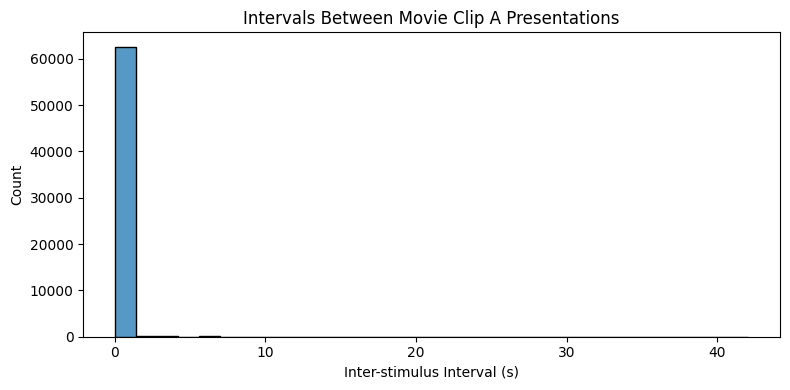

In [12]:
intervals = nwb.intervals
movie_a = intervals["movie_clip_A_presentations"].to_dataframe()
print("Movie Clip A presentations, first 5:")
display(movie_a.head())
print("Number of Movie A presentations:", movie_a.shape[0])

plt.figure(figsize=(8, 4))
sns.histplot(movie_a["start_time"].diff().dropna(), bins=30)
plt.xlabel("Inter-stimulus Interval (s)")
plt.title("Intervals Between Movie Clip A Presentations")
plt.tight_layout()
plt.show()

## 11. Next Steps and Further Exploration

You can adapt and extend this notebook to:
- Analyze stimulus-driven calcium responses
- Compare behavioral state (running/engaged vs. passive)
- Examine response reliability across trials and conditions
- Explore sequence learning effects (across days / sessions)
- Investigate different brain regions and layers

The Dandiset's structure and organization allow for efficient programmatic access to all subjects and sessions.

---

For more, see:  
- [DANDI User Guide](https://www.dandiarchive.org/)  
- [Allen Brain Observatory](https://portal.brain-map.org/explore/circuits/visual-coding-2p)  

Happy exploring!

---

*This notebook was generated with the assistance of AI based on the provided Dandiset structure and metadata. Please cite the Dandiset and refer to the associated protocols and Allen Institute documentation for experimental and analysis details.*